[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/

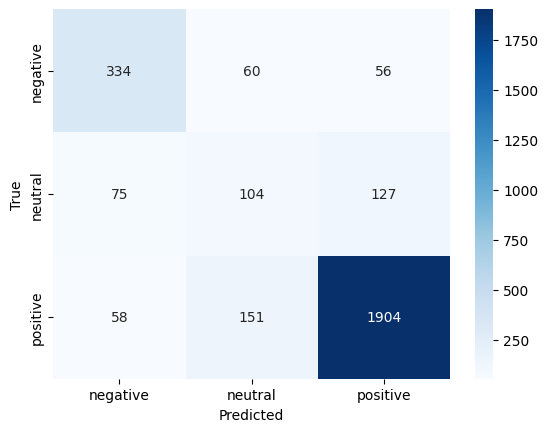

Epoch 1/20, Loss: 0.5697, Accuracy: 0.7551
Epoch 2/20, Loss: 0.5052, Accuracy: 0.7910
Epoch 3/20, Loss: 0.4755, Accuracy: 0.8025
Epoch 4/20, Loss: 0.4471, Accuracy: 0.8139
Epoch 5/20, Loss: 0.4134, Accuracy: 0.8307
Epoch 6/20, Loss: 0.3765, Accuracy: 0.8489
Epoch 7/20, Loss: 0.3415, Accuracy: 0.8653
Epoch 8/20, Loss: 0.3090, Accuracy: 0.8795
Epoch 9/20, Loss: 0.2752, Accuracy: 0.8954
Epoch 10/20, Loss: 0.2468, Accuracy: 0.9062
Epoch 11/20, Loss: 0.2194, Accuracy: 0.9167
Epoch 12/20, Loss: 0.1961, Accuracy: 0.9275
Epoch 13/20, Loss: 0.1735, Accuracy: 0.9353
Epoch 14/20, Loss: 0.1568, Accuracy: 0.9427
Epoch 15/20, Loss: 0.1383, Accuracy: 0.9490
Epoch 16/20, Loss: 0.1245, Accuracy: 0.9559
Epoch 17/20, Loss: 0.1141, Accuracy: 0.9593
Epoch 18/20, Loss: 0.1009, Accuracy: 0.9632
Epoch 19/20, Loss: 0.0906, Accuracy: 0.9673
Epoch 20/20, Loss: 0.0841, Accuracy: 0.9710

 Validation 2/5, Validation Accuracy: 0.7999
              precision    recall  f1-score   support

    negative       0.71     

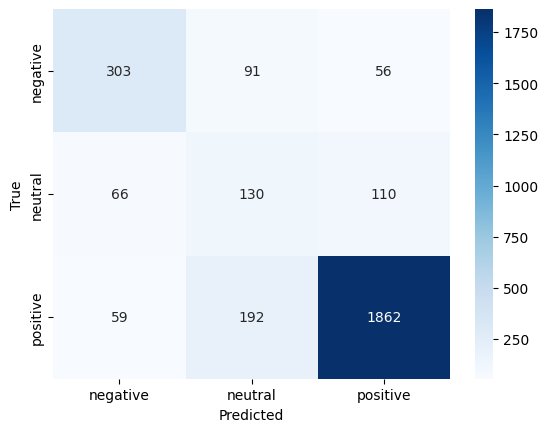

Epoch 1/20, Loss: 0.5727, Accuracy: 0.7535
Epoch 2/20, Loss: 0.5037, Accuracy: 0.7885
Epoch 3/20, Loss: 0.4696, Accuracy: 0.8035
Epoch 4/20, Loss: 0.4348, Accuracy: 0.8214
Epoch 5/20, Loss: 0.3964, Accuracy: 0.8380
Epoch 6/20, Loss: 0.3596, Accuracy: 0.8569
Epoch 7/20, Loss: 0.3218, Accuracy: 0.8728
Epoch 8/20, Loss: 0.2842, Accuracy: 0.8892
Epoch 9/20, Loss: 0.2520, Accuracy: 0.9048
Epoch 10/20, Loss: 0.2271, Accuracy: 0.9146
Epoch 11/20, Loss: 0.1964, Accuracy: 0.9265
Epoch 12/20, Loss: 0.1779, Accuracy: 0.9332
Epoch 13/20, Loss: 0.1612, Accuracy: 0.9412
Epoch 14/20, Loss: 0.1433, Accuracy: 0.9476
Epoch 15/20, Loss: 0.1298, Accuracy: 0.9517
Epoch 16/20, Loss: 0.1178, Accuracy: 0.9577
Epoch 17/20, Loss: 0.1028, Accuracy: 0.9629
Epoch 18/20, Loss: 0.0911, Accuracy: 0.9670
Epoch 19/20, Loss: 0.0845, Accuracy: 0.9698
Epoch 20/20, Loss: 0.0792, Accuracy: 0.9723

 Validation 3/5, Validation Accuracy: 0.8121
              precision    recall  f1-score   support

    negative       0.75     

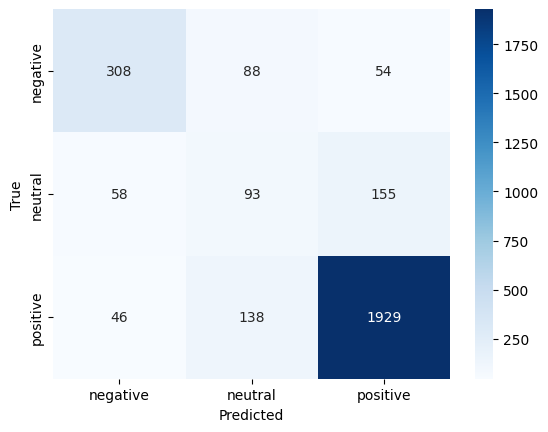

Epoch 1/20, Loss: 0.5669, Accuracy: 0.7528
Epoch 2/20, Loss: 0.5008, Accuracy: 0.7876
Epoch 3/20, Loss: 0.4707, Accuracy: 0.8016
Epoch 4/20, Loss: 0.4406, Accuracy: 0.8191
Epoch 5/20, Loss: 0.4055, Accuracy: 0.8345
Epoch 6/20, Loss: 0.3700, Accuracy: 0.8529
Epoch 7/20, Loss: 0.3331, Accuracy: 0.8692
Epoch 8/20, Loss: 0.2998, Accuracy: 0.8856
Epoch 9/20, Loss: 0.2699, Accuracy: 0.8969
Epoch 10/20, Loss: 0.2381, Accuracy: 0.9098
Epoch 11/20, Loss: 0.2140, Accuracy: 0.9213
Epoch 12/20, Loss: 0.1933, Accuracy: 0.9287
Epoch 13/20, Loss: 0.1731, Accuracy: 0.9378
Epoch 14/20, Loss: 0.1485, Accuracy: 0.9459
Epoch 15/20, Loss: 0.1346, Accuracy: 0.9530
Epoch 16/20, Loss: 0.1181, Accuracy: 0.9588
Epoch 17/20, Loss: 0.1090, Accuracy: 0.9617
Epoch 18/20, Loss: 0.0978, Accuracy: 0.9630
Epoch 19/20, Loss: 0.0885, Accuracy: 0.9685
Epoch 20/20, Loss: 0.0813, Accuracy: 0.9711

 Validation 4/5, Validation Accuracy: 0.8197
              precision    recall  f1-score   support

    negative       0.70     

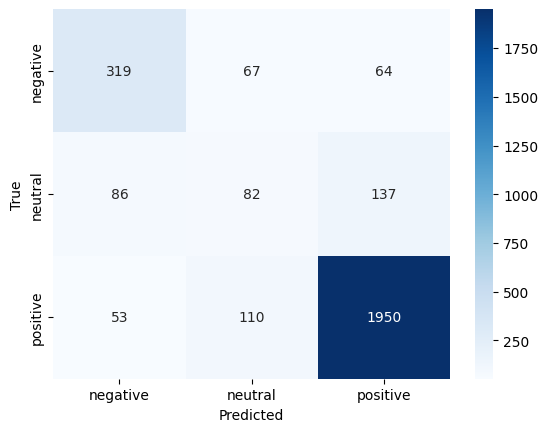

Epoch 1/20, Loss: 0.5807, Accuracy: 0.7498
Epoch 2/20, Loss: 0.5174, Accuracy: 0.7843
Epoch 3/20, Loss: 0.4849, Accuracy: 0.7977
Epoch 4/20, Loss: 0.4549, Accuracy: 0.8146
Epoch 5/20, Loss: 0.4195, Accuracy: 0.8309
Epoch 6/20, Loss: 0.3855, Accuracy: 0.8470
Epoch 7/20, Loss: 0.3512, Accuracy: 0.8615
Epoch 8/20, Loss: 0.3158, Accuracy: 0.8794
Epoch 9/20, Loss: 0.2775, Accuracy: 0.8949
Epoch 10/20, Loss: 0.2446, Accuracy: 0.9075
Epoch 11/20, Loss: 0.2187, Accuracy: 0.9204
Epoch 12/20, Loss: 0.1947, Accuracy: 0.9277
Epoch 13/20, Loss: 0.1743, Accuracy: 0.9372
Epoch 14/20, Loss: 0.1552, Accuracy: 0.9430
Epoch 15/20, Loss: 0.1399, Accuracy: 0.9495
Epoch 16/20, Loss: 0.1261, Accuracy: 0.9543
Epoch 17/20, Loss: 0.1122, Accuracy: 0.9587
Epoch 18/20, Loss: 0.0995, Accuracy: 0.9642
Epoch 19/20, Loss: 0.0915, Accuracy: 0.9675
Epoch 20/20, Loss: 0.0830, Accuracy: 0.9702

 Validation 5/5, Validation Accuracy: 0.7925
              precision    recall  f1-score   support

    negative       0.70     

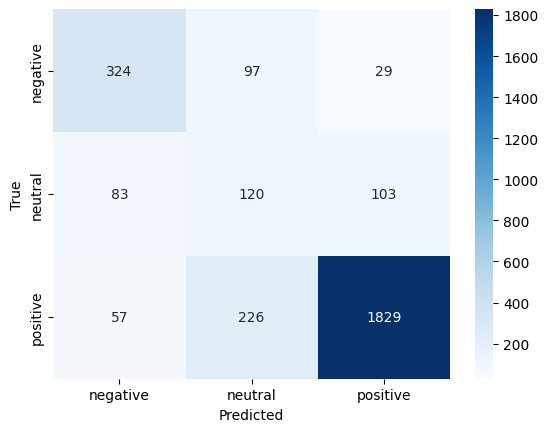

Final Test Accuracy: 0.8128
Final Confusion Matrix:
[[ 714  136  114]
 [ 165  157  333]
 [ 118  285 4126]]

Final Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.74      0.73       964
     neutral       0.27      0.24      0.25       655
    positive       0.90      0.91      0.91      4529

    accuracy                           0.81      6148
   macro avg       0.63      0.63      0.63      6148
weighted avg       0.81      0.81      0.81      6148



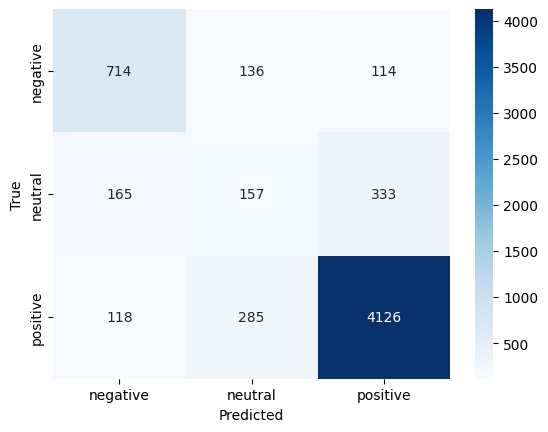

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import Word2Vec
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import normalize
import multiprocessing
import time

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
data_path = '/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv'
data = pd.read_csv(data_path)

# Preprocessing: Text Cleaning, Tokenization, and Normalization
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['Cleaned_Review'] = data['Review'].apply(preprocess_text)

# Create sentiment labels from ratings
def rating_to_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

data['Sentiment'] = data['Rating'].apply(rating_to_sentiment)

# Convert 'Sentiment' column to category
data['Sentiment'] = data['Sentiment'].astype('category')

# Split data into train and test sets
train_data, test_data = train_test_split(
    data, test_size=0.3, stratify=data['Sentiment'], random_state=42
)

# Print sentiment counts in training and test sets
print("Sentiment counts in training set:")
print(train_data['Sentiment'].value_counts())

print("\nSentiment counts in testing set:")
print(test_data['Sentiment'].value_counts())

# Prepare sentences for Word2Vec
train_sentences = [nltk.word_tokenize(text) for text in train_data['Cleaned_Review']]
test_sentences = [nltk.word_tokenize(text) for text in test_data['Cleaned_Review']]

# Train Word2Vec model
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

t = time.time()
w2v_model.build_vocab(train_sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

t = time.time()
w2v_model.train(train_sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

# Convert text data to Word2Vec vectors (average of word vectors)
def text_to_vector(text):
    tokens = nltk.word_tokenize(text.lower())
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

train_vectors = np.array([text_to_vector(text) for text in train_data['Cleaned_Review']])
test_vectors = np.array([text_to_vector(text) for text in test_data['Cleaned_Review']])

# Normalize vectors
train_vectors = normalize(train_vectors, axis=1)
test_vectors = normalize(test_vectors, axis=1)

train_labels = train_data['Sentiment']
test_labels = test_data['Sentiment']

# Define BiLSTM model
class SentimentBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(SentimentBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # hidden_size * 2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add dimension for seq_length
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # * 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # * 2 for bidirectional
        bilstm_out, _ = self.bilstm(x, (h0, c0))
        bilstm_out = self.dropout(bilstm_out)
        bilstm_out = bilstm_out[:, -1, :]
        output = self.fc(bilstm_out)
        return output

# Cross-validation and hyperparameter tuning
def cross_validate_and_tune(vectors, labels, num_folds=5, num_epochs=20):
    skf = StratifiedKFold(n_splits=num_folds)
    best_model = None
    best_acc = 0.0
    
    for num_evaluation, (train_index, val_index) in enumerate(skf.split(vectors, labels)):
        X_train, X_val = vectors[train_index], vectors[val_index]
        y_train, y_val = labels.iloc[train_index], labels.iloc[val_index]

        # Apply SMOTE to the training data
        smote = SMOTE(sampling_strategy='auto', random_state=42)  
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        # Convert to tensors
        X_train_tensor = torch.tensor(X_train_smote, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(pd.Series(y_train_smote).cat.codes.values, dtype=torch.long).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(pd.Series(y_val).cat.codes.values, dtype=torch.long).to(device)
        
        # Define parameters
        input_size = 300  # Size of Word2Vec word vectors
        hidden_size = 128
        output_size = len(data['Sentiment'].unique())
        
        # Calculate class weights
        class_counts = Counter(y_train_smote)
        total_samples = len(y_train_smote)
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        class_weights_tensor = torch.tensor([class_weights[cls] for cls in sorted(class_counts.keys())], dtype=torch.float32).to(device)
        
        # Create BiLSTM model instance
        bilstm_model = SentimentBiLSTM(input_size, hidden_size, output_size, num_layers=2, dropout=0.3).to(device)

        # Define optimizer and loss function
        optimizer = optim.Adam(bilstm_model.parameters(), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
        
        # Define DataLoader
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

        # Training loop
        def train_model(model, train_loader, optimizer, loss_fn, num_epochs):
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct_predictions = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    correct_predictions += (predicted == labels).sum().item()

                epoch_loss = running_loss / len(train_loader.dataset)
                epoch_acc = correct_predictions / len(train_loader.dataset)
                print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            return model

        # Train the model
        trained_model = train_model(bilstm_model, train_loader, optimizer, loss_fn, num_epochs)

        # Evaluate the model
        def evaluate_model(model, X_val_tensor, y_val_tensor):
            model.eval()
            with torch.no_grad():
                outputs = model(X_val_tensor)
                _, predicted = torch.max(outputs, 1)
                acc = (predicted == y_val_tensor).sum().item() / len(y_val_tensor)
                cm = confusion_matrix(y_val_tensor.cpu(), predicted.cpu())
                cr = classification_report(y_val_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
            return acc, cm, cr

        val_acc, val_cm, val_cr = evaluate_model(trained_model, X_val_tensor, y_val_tensor)
        print(f'\n Validation {num_evaluation + 1}/{num_folds}, Validation Accuracy: {val_acc:.4f}')
        print(val_cr)
        print(f'\nConfusion Matrix:\n{val_cm}\n')
        sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = trained_model
    return best_model

# Perform cross-validation and get the best model
labels = train_labels
best_model = cross_validate_and_tune(train_vectors, labels)

# Final evaluation on test set
def final_evaluation(model, test_vectors_tensor, test_labels_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(test_vectors_tensor)
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == test_labels_tensor).sum().item() / len(test_labels_tensor)
        cm = confusion_matrix(test_labels_tensor.cpu(), predicted.cpu())
        cr = classification_report(test_labels_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
    return acc, cm, cr

# Convert test data to tensors
test_vectors_tensor = torch.tensor(test_vectors, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels.cat.codes.values, dtype=torch.long).to(device)

# Evaluate the best model on the entire test set
final_acc, final_cm, final_cr = final_evaluation(best_model, test_vectors_tensor, test_labels_tensor)
print(f"Final Test Accuracy: {final_acc:.4f}")
print("Final Confusion Matrix:")
print(final_cm)
print("\nFinal Classification Report:")
print(final_cr)
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
